In [1]:
# Importamos las librerías

import nltk
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df_coments_a = pd.read_csv("twitter_coments_sasil.csv", usecols=["css-901oao", "css-901oao 4", "css-901oao 5",
                                                              "css-901oao 6", "css-901oao 7"])
df_coments_a = df_coments_a.fillna('')

df_coments_a["texto"] = df_coments_a["css-901oao"] + ' ' + df_coments_a["css-901oao 5"] + ' ' + df_coments_a["css-901oao 6"] + ' ' + df_coments_a["css-901oao 7"]
df_coments_a = pd.DataFrame(df_coments_a["texto"])
################
df_coments_b = pd.read_csv("twitter_coments_b.csv", usecols=["css-901oao 2", "css-901oao 4"])
df_coments_b = df_coments_b.fillna('')
df_coments_b = df_coments_b.rename(columns={"css-901oao 4":"texto"})
df_coments_b = pd.DataFrame(df_coments_b["texto"])

In [3]:
df_coments = pd.concat([df_coments_a, df_coments_b])

from nltk.tokenize import RegexpTokenizer

df_coments['texto'] = df_coments['texto'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
df_coments['tokens'] = df_coments['texto'].apply(tokenizer.tokenize)
df_coments

texto  \
0   diego victorio sasil de león , son los tres as...   
1                      alerta chiapas sasil de león .   
2                                    sasil de león      
3   pamela hernández sasil de león , roberto albor...   
4                                         personas      
..                                                ...   
78                                          traidores   
79                                                 xd   
80                                lifestylelatino.com   
81                                   tu eres verde !!   
82  desgraciada corrupta, los chiapanecos te conoc...   

                                               tokens  
0   [diego, victorio, sasil, de, león, son, los, t...  
1                  [alerta, chiapas, sasil, de, león]  
2                                   [sasil, de, león]  
3   [pamela, hernández, sasil, de, león, roberto, ...  
4                                          [personas]  
..                                                ...  
78                                        [traidores]  
79                                               [xd]  
80                             [lifestylelatino, com]  
81                                  [tu, eres, verde]  
82  [desgraciada, corrupta, los, chiapanecos, te, ...  

[120 rows x 2 columns]

In [4]:
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')

nltk.download('punkt')

# Análisis de polaridad
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va",
                   "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "dra"))


# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = df_coments[~(df_coments["tokens"].isin(stop_words))]
tweets_tidy

[nltk_data] Downloading package stopwords to /home/cygnus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cygnus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


texto  \
0   diego victorio sasil de león , son los tres as...   
1                      alerta chiapas sasil de león .   
2                                    sasil de león      
3   pamela hernández sasil de león , roberto albor...   
4                                         personas      
..                                                ...   
78                                          traidores   
79                                                 xd   
80                                lifestylelatino.com   
81                                   tu eres verde !!   
82  desgraciada corrupta, los chiapanecos te conoc...   

                                               tokens  
0   [diego, victorio, sasil, de, león, son, los, t...  
1                  [alerta, chiapas, sasil, de, león]  
2                                   [sasil, de, león]  
3   [pamela, hernández, sasil, de, león, roberto, ...  
4                                          [personas]  
..                                                ...  
78                                        [traidores]  
79                                               [xd]  
80                             [lifestylelatino, com]  
81                                  [tu, eres, verde]  
82  [desgraciada, corrupta, los, chiapanecos, te, ...  

[120 rows x 2 columns]

In [20]:
##########NUBE DE PALABRAS
def preprocess_text(text):
    words = text # Tokenizar y convertir a minúsculas
    words = [word for word in words if word.isalpha()]  # Eliminar caracteres no alfabéticos
    words = [word for word in words if word not in stop_words]  # Eliminar palabras vacías
    return words


preprocessed_text = tweets_tidy["tokens"].apply(preprocess_text)

# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in preprocessed_text.values for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(20)
top_words.to_csv("top_words_coments_twitter.csv")
type(top_words)

pandas.core.series.Series

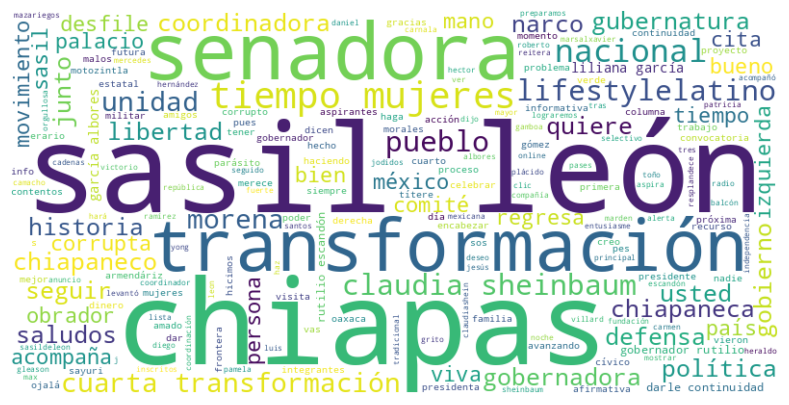

In [22]:
# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)

# Crear el objeto WordCloud
nube_palabras = WordCloud(width=800, height=400, background_color='white').generate(texto)


# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(15, 5))
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
# Guardar la figura como una imagen
plt.savefig('nube_palabras.png', bbox_inches='tight', dpi=300)
plt.show()

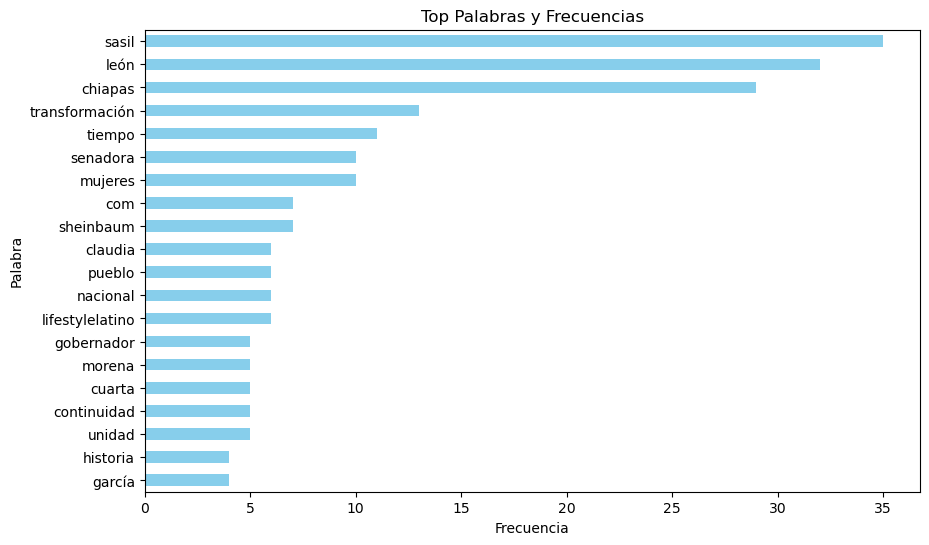

In [7]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
top_words.plot(kind='barh', color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Top Palabras y Frecuencias')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la palabra con la frecuencia más alta en la parte superior
plt.show()

In [8]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Supongamos que tienes un corpus de textos en una lista llamada 'corpus_textos'
texts = tweets_tidy.tokens

punctuation = set(string.punctuation)

texts = [[word for word in doc if word not in stop_words and word not in punctuation] for doc in texts]

# Crear un diccionario de términos a partir del corpus
dictionary = corpora.Dictionary(texts)

# Crear una representación vectorial del corpus
corpus = [dictionary.doc2bow(text) for text in texts]

In [9]:
# Entrenar el modelo LDA
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=8)

# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=5)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.028*"chiapas" + 0.023*"sasil" + 0.023*"león" + 0.017*"saludos" + 0.014*"gobernadora"')
(1, '0.022*"narco" + 0.021*"continuidad" + 0.016*"darle" + 0.016*"chiapas" + 0.011*"hecho"')
(2, '0.022*"tiempo" + 0.022*"transformación" + 0.017*"chiapas" + 0.016*"mujeres" + 0.014*"sasil"')
(3, '0.053*"sasil" + 0.049*"león" + 0.022*"chiapas" + 0.019*"com" + 0.019*"lifestylelatino"')
(4, '0.028*"chiapas" + 0.027*"sasil" + 0.024*"león" + 0.012*"cita" + 0.012*"sheinbaum"')


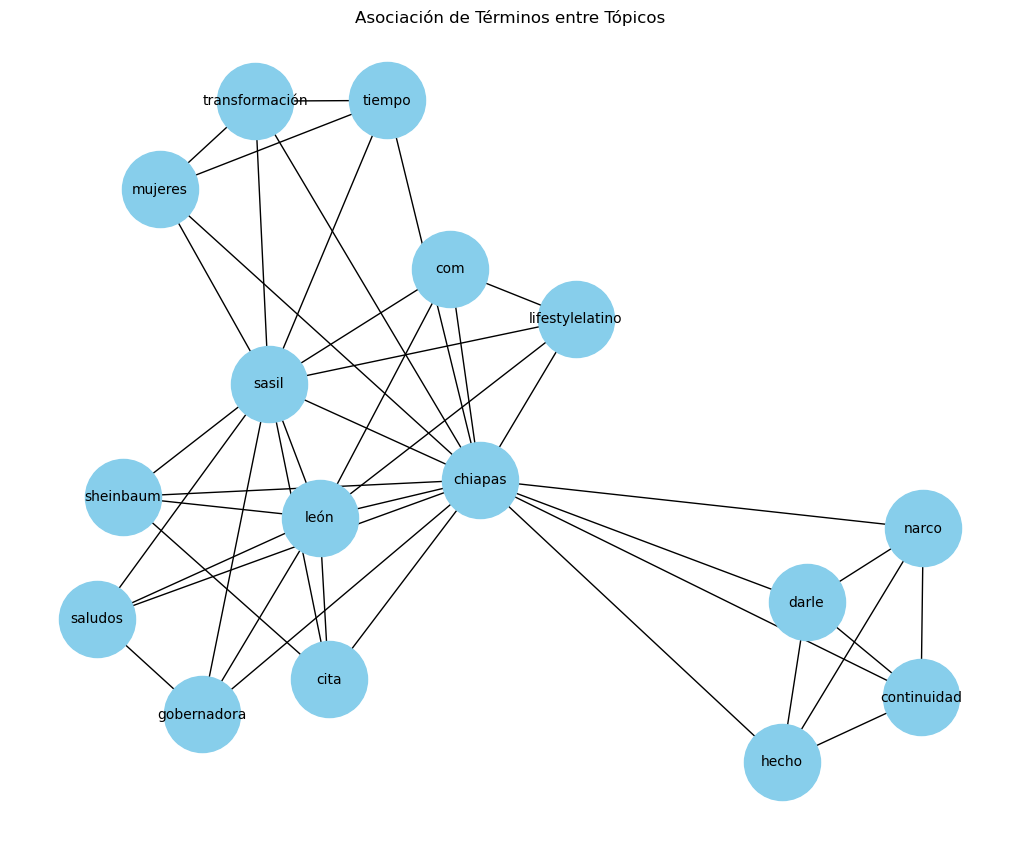

In [10]:
import networkx as nx
import matplotlib.pyplot as plt


# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='skyblue', font_color='black')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
plt.show()

In [18]:
import re

tweets_tidy['texto'] = tweets_tidy['texto'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

# Función para obtener el sentimiento de un texto
def obtener_sentimiento(texto):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(texto)["compound"]

# Aplicar la función a la columna "texto" y crear una nueva columna "sentimiento"
tweets_tidy["sentimiento"] = tweets_tidy["texto"].apply(obtener_sentimiento)
tweets_tidy.to_csv("tweets_coments_sentiment.csv")

In [17]:
import plotly.graph_objects as go

####################################
# Contar la cantidad de sentimientos negativos, neutros y positivos
negativos = tweets_tidy[tweets_tidy["sentimiento"] < 0].count().values[0]
neutros = tweets_tidy[tweets_tidy["sentimiento"] == 0].count().values[0]
positivos = tweets_tidy[tweets_tidy["sentimiento"] > 0].count().values[0]

# Crear la gráfica de pastel
labels = ["Negativos", "Neutros", "Positivos"]
values = [negativos, neutros, positivos]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

fig.write_html("pie.html")
# Mostrar la gráfica
fig.show()